In [ ]:
import sys
import os

# 1) Point Python to your NexFileReaders folder
sys.path.append(r"D:\KILOSORT\James\nex_sdk")

import NexFileReaders
from NexFileData import FileData

# 2) Standard Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from matplotlib.patches import Ellipse

# 3) Machine learning
from sklearn.decomposition import PCA

# 4) Distance computations
from scipy.spatial import distance

In [85]:
# Path to your .nex file
nex_path = r"D:\KILOSORT\James\Data\test_unsorted.nex"

# Create a NexFileReader for .nex files
reader = NexFileReaders.NexFileReader()
fileData = reader.ReadNexFile(nex_path)

# Check how many waveforms were found
print(f"Found {len(fileData.Waveforms)} waveform variables in {nex_path}.")

Found 89 waveform variables in D:\KILOSORT\James\Data\test_unsorted.nex.


In [86]:
records = []

for wf in fileData.Waveforms:
    unit_name = wf.Name
    timestamps = wf.Timestamps      # e.g. [ts0, ts1, ts2, ...]
    wave_values = wf.Values         # e.g. [[v0..v31], [v0..v31], ...]

    # Confirm wave_values is NxM: N=spikes, M=samples
    # print(f"Unit {unit_name}: #Spikes = {len(timestamps)}, Waveform length = {len(wave_values[0])} samples")

    # Build table rows
    for ts, vals in zip(timestamps, wave_values):
        # Peak-to-peak amplitude
        amplitude = float(np.ptp(vals))  # np.ptp -> max(vals) - min(vals)
        # Flatten each sample into v0..vM
        row_dict = {
            "Name": unit_name,
            "Timestamp": ts,
            "Amplitude": amplitude
        }
        # Add each sample as v0..vM
        for i, val in enumerate(vals):
            row_dict[f"v{i}"] = val
        records.append(row_dict)

df = pd.DataFrame(records)
print(f"DataFrame shape: {df.shape}")
df.head()

DataFrame shape: (396032, 35)


Name  Timestamp  Amplitude        v0        v1        v2        v3  \
0  SPK01U_wf   1.407250   0.189514 -0.059509 -0.063477 -0.054321 -0.054016   
1  SPK01U_wf   1.408775   0.136108  0.000000 -0.002441 -0.024414 -0.036621   
2  SPK01U_wf   1.518125   0.103760 -0.004883 -0.000305 -0.011292 -0.037537   
3  SPK01U_wf   3.030925   0.057678 -0.061646 -0.064697 -0.065918 -0.053406   
4  SPK01U_wf   3.423500   0.060120 -0.013123 -0.016479 -0.026550 -0.037231   

         v4        v5        v6  ...       v22       v23       v24       v25  \
0 -0.063171 -0.059204 -0.059814  ... -0.079346 -0.069275 -0.059204 -0.045471   
1 -0.054626 -0.058899 -0.060120  ... -0.079041 -0.075073 -0.060730 -0.053711   
2 -0.047302 -0.059814 -0.064087  ... -0.025330 -0.026245 -0.028076 -0.004578   
3 -0.058899 -0.048523 -0.055847  ... -0.069885 -0.069580 -0.062866 -0.057068   
4 -0.050049 -0.067444 -0.065002  ... -0.035095 -0.036621 -0.026855 -0.025330   

        v26       v27       v28       v29       v30       v31  
0 -0.024719 -0.002441  0.021973  0.041504  0.054626  0.081787  
1 -0.042725 -0.027771 -0.015259 -0.007324 -0.009460 -0.007019  
2  0.002136 -0.005493  0.000916 -0.005493 -0.007324 -0.005493  
3 -0.049133 -0.048523 -0.047607 -0.040283 -0.035095 -0.042419  
4 -0.025330 -0.025635 -0.025330 -0.015564 -0.013428 -0.020752  

[5 rows x 35 columns]

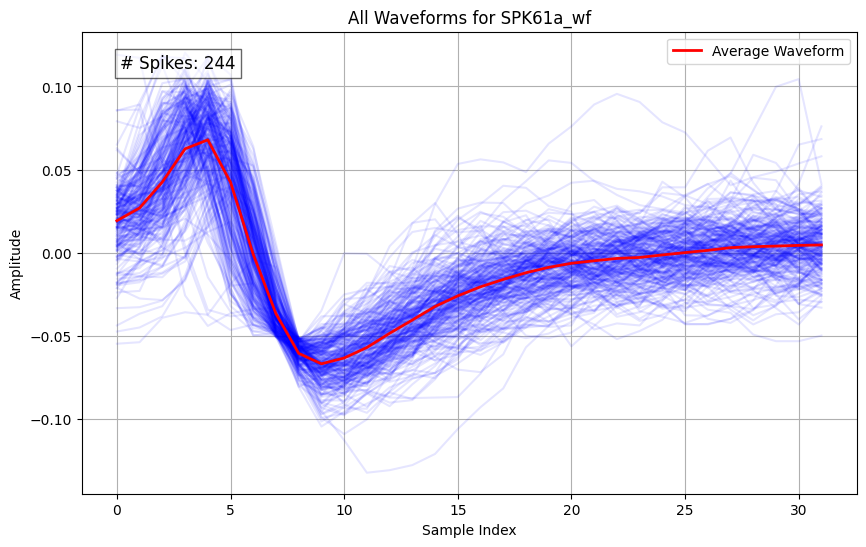

In [110]:
# Filter DataFrame for the specific unit
unit_name = "SPK61a_wf"
df_unit = df[df["Name"] == unit_name]
n_spikes = len(df_unit)

# Identify the waveform columns (v0, v1, ..., v31)
waveform_cols = [col for col in df.columns if col.startswith("v")]

plt.figure(figsize=(10, 6))
# Plot each spike's waveform with low opacity
for idx, row in df_unit.iterrows():
    waveform = row[waveform_cols].values.astype(float)
    plt.plot(waveform, color="blue", alpha=0.1)

# Plot the average waveform in red
mean_waveform = df_unit[waveform_cols].mean().values.astype(float)
plt.plot(mean_waveform, color="red", linewidth=2, label="Average Waveform")

# Annotate the plot with the number of spikes
plt.text(0.05, 0.95, f"# Spikes: {n_spikes}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

plt.title(f"All Waveforms for {unit_name}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [87]:
# Identify waveform columns
waveform_cols = [c for c in df.columns if c.startswith("v")]

# Extract waveforms into matrix X
X = df[waveform_cols].values  # shape: (#spikes, #samples)

# Fit PCA with 3 components
pca = PCA(n_components=3)
pcs = pca.fit_transform(X)

# Store PC scores in df
df["PC1"] = pcs[:, 0]
df["PC2"] = pcs[:, 1]
df["PC3"] = pcs[:, 2]

print("Explained variance ratio:", pca.explained_variance_ratio_)
df.head()

Explained variance ratio: [0.6430726  0.14092231 0.10661237]


Name  Timestamp  Amplitude        v0        v1        v2        v3  \
0  SPK01U_wf   1.407250   0.189514 -0.059509 -0.063477 -0.054321 -0.054016   
1  SPK01U_wf   1.408775   0.136108  0.000000 -0.002441 -0.024414 -0.036621   
2  SPK01U_wf   1.518125   0.103760 -0.004883 -0.000305 -0.011292 -0.037537   
3  SPK01U_wf   3.030925   0.057678 -0.061646 -0.064697 -0.065918 -0.053406   
4  SPK01U_wf   3.423500   0.060120 -0.013123 -0.016479 -0.026550 -0.037231   

         v4        v5        v6  ...       v25       v26       v27       v28  \
0 -0.063171 -0.059204 -0.059814  ... -0.045471 -0.024719 -0.002441  0.021973   
1 -0.054626 -0.058899 -0.060120  ... -0.053711 -0.042725 -0.027771 -0.015259   
2 -0.047302 -0.059814 -0.064087  ... -0.004578  0.002136 -0.005493  0.000916   
3 -0.058899 -0.048523 -0.055847  ... -0.057068 -0.049133 -0.048523 -0.047607   
4 -0.050049 -0.067444 -0.065002  ... -0.025330 -0.025330 -0.025635 -0.025330   

        v29       v30       v31       PC1       PC2       PC3  
0  0.041504  0.054626  0.081787 -0.198262 -0.180281  0.113718  
1 -0.007324 -0.009460 -0.007019 -0.272220 -0.184388  0.036638  
2 -0.005493 -0.007324 -0.005493 -0.083303 -0.126332  0.005413  
3 -0.040283 -0.035095 -0.042419 -0.231358 -0.086176 -0.028973  
4 -0.015564 -0.013428 -0.020752 -0.110830 -0.055082 -0.000859  

[5 rows x 38 columns]

In [88]:
import re

# Define a helper function to extract channel and unit letter from a name.
def extract_channel_and_unit(name):
    # The pattern assumes the name starts with "SPK" followed by two digits (channel),
    # then a letter representing the unit (e.g., 'a' or 'b').
    match = re.match(r"^(SPK\d{2})([a-zA-Z])", name)
    if match:
        channel = match.group(1)      # e.g., "SPK01"
        unit_letter = match.group(2)  # e.g., "a"
        return channel, unit_letter
    else:
        return None, None

# Apply the extraction function to the "Name" column to create new columns.
df[['Channel', 'UnitLetter']] = df['Name'].apply(lambda x: pd.Series(extract_channel_and_unit(x)))

# Group by the channel and count the unique unit letters.
unit_summary = df.groupby('Channel')['UnitLetter'].nunique().reset_index()
unit_summary = unit_summary.rename(columns={'UnitLetter': 'UnitCount'})

# Also, create a column listing the unique unit letters for each channel.
unit_letters = df.groupby('Channel')['UnitLetter'].unique().reset_index()
unit_letters['UnitLetters'] = unit_letters['UnitLetter'].apply(lambda x: ", ".join(sorted(x)))
unit_letters = unit_letters.drop(columns=['UnitLetter'])

# Merge the counts with the list of unit letters.
summary_table = pd.merge(unit_summary, unit_letters, on='Channel')

# Display the summary table
print(summary_table)

   Channel  UnitCount UnitLetters
0    SPK01          3     U, a, b
1    SPK02          1           U
2    SPK03          1           U
3    SPK04          2        U, a
4    SPK05          2        U, a
..     ...        ...         ...
59   SPK60          1           U
60   SPK61          2        U, a
61   SPK62          1           U
62   SPK63          1           U
63   SPK64          1           U

[64 rows x 3 columns]


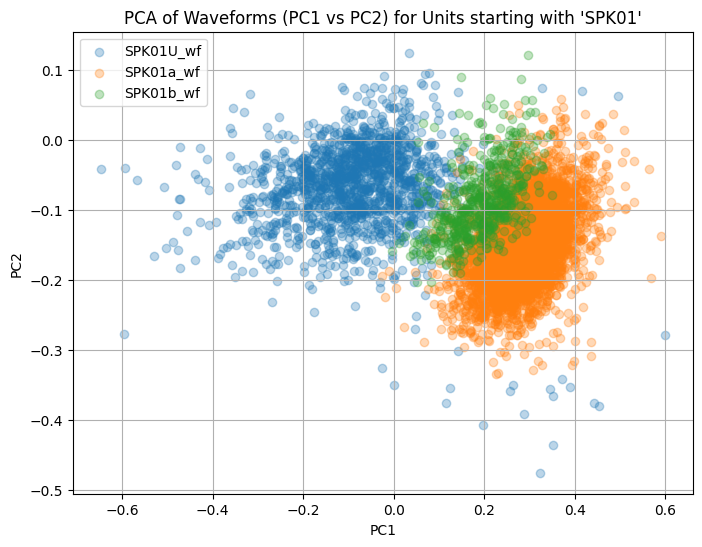

In [90]:
# Filter DataFrame for rows with unit names starting with "SPK01"
subset_df = df[df["Name"].str.startswith("SPK01")]

plt.figure(figsize=(8,6))
for name, group in subset_df.groupby("Name"):
    # If the unit name ends with 'template', plot with full opacity (solid)
    if name.endswith("template"):
        marker_alpha = 1.0
    else:
        marker_alpha = 0.3
    plt.scatter(group["PC1"], group["PC2"], label=name, alpha=marker_alpha)

plt.title("PCA of Waveforms (PC1 vs PC2) for Units starting with 'SPK01'")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

In [91]:

# --- Step 1. Parse Channel and Unit from the spike Name ---
def extract_channel_unit(name):
    """
    Extracts the channel (e.g., "SPK01") and unit letter (e.g., "a" or "U") 
    from a name string of the form "SPK##x_wf"
    """
    m = re.match(r"(SPK\d{2})([a-zA-Z])_wf", name)
    if m:
        return m.group(1), m.group(2)
    else:
        return None, None

# If not already present, add "Channel" and "UnitLetter" columns to the DataFrame.
# (Assuming your DataFrame 'df' already contains columns: "Name", "PC1", "PC2", "PC3", etc.)
if 'Channel' not in df.columns or 'UnitLetter' not in df.columns:
    df[['Channel', 'UnitLetter']] = df['Name'].apply(lambda x: pd.Series(extract_channel_unit(x)))

In [93]:
# --- Step 2. Define function to compute isolation distance ---
def compute_iso_distance(cluster, background):
    """
    Computes the isolation distance for a given sorted cluster 'cluster' relative to the 
    'background' spikes. Both inputs should be arrays of shape (n_spikes, n_features),
    where n_features is the number of principal components (e.g., 3).
    
    The isolation distance is defined as the squared Mahalanobis distance of the n-th 
    closest background spike (where n is the number of spikes in the cluster) to the 
    cluster's center.
    """
    n = cluster.shape[0]
    if n == 0 or background.shape[0] < n:
        return np.nan
    mean_cluster = np.mean(cluster, axis=0)
    cov_cluster = np.cov(cluster, rowvar=False)
    try:
        inv_cov = np.linalg.inv(cov_cluster)
    except np.linalg.LinAlgError:
        return np.nan
    # Compute squared Mahalanobis distance for each background spike:
    dists_sq = np.array([np.dot((x - mean_cluster).T, np.dot(inv_cov, (x - mean_cluster))) for x in background])
    dists_sq_sorted = np.sort(dists_sq)
    if len(dists_sq_sorted) >= n:
        iso_distance = dists_sq_sorted[n - 1]  # the n-th smallest squared distance
    else:
        iso_distance = np.nan
    return iso_distance

In [97]:
# --- Step 3. Loop over channels and compute pairwise comparisons ---
results = []
channels = df['Channel'].unique()
for ch in channels:
    # Select all spikes from this channel
    df_ch = df[df['Channel'] == ch]
    
    # Separate sorted units (UnitLetter != 'U') and unsorted spikes (UnitLetter == 'U')
    sorted_units = df_ch[df_ch['UnitLetter'] != 'U']
    unsorted_units = df_ch[df_ch['UnitLetter'] == 'U']
    
    # Get unique sorted unit letters (e.g., ['a', 'b', ...])
    sorted_unit_letters = sorted(sorted_units['UnitLetter'].unique())
    
    # We only process channels that have at least one sorted unit.
    if len(sorted_unit_letters) == 0:
        continue

    # Comparison 1: For each sorted unit, compare to unsorted spikes (if available)
    if len(unsorted_units) > 0:
        for unit in sorted_unit_letters:
            cluster = sorted_units[sorted_units['UnitLetter'] == unit][['PC1', 'PC2', 'PC3']].values
            background = unsorted_units[['PC1', 'PC2', 'PC3']].values
            iso_dist = compute_iso_distance(cluster, background)
            results.append({'Channel': ch, 'Comparison': f"{unit} vs U", 'IsoDistance': iso_dist})
    
    # Comparison 2: For each pair of sorted units, compute isolation distance (one direction)
    if len(sorted_unit_letters) >= 2:
        for i in range(len(sorted_unit_letters)):
            for j in range(i + 1, len(sorted_unit_letters)):
                unit1 = sorted_unit_letters[i]
                unit2 = sorted_unit_letters[j]
                # Compute for unit1 relative to unit2 (background)
                cluster = sorted_units[sorted_units['UnitLetter'] == unit1][['PC1', 'PC2', 'PC3']].values
                background = sorted_units[sorted_units['UnitLetter'] == unit2][['PC1', 'PC2', 'PC3']].values
                iso_dist = compute_iso_distance(cluster, background)
                results.append({'Channel': ch, 'Comparison': f"{unit1} vs {unit2}", 'IsoDistance': iso_dist})

# Convert the results to a DataFrame and display it
results_df = pd.DataFrame(results)
print(results_df)

   Channel Comparison  IsoDistance
0    SPK01     a vs U          NaN
1    SPK01     b vs U    26.158419
2    SPK01     a vs b          NaN
3    SPK04     a vs U     9.363811
4    SPK05     a vs U    10.119067
5    SPK06     a vs U     1.569583
6    SPK29     a vs U    11.999389
7    SPK30     a vs U          NaN
8    SPK30     b vs U    13.561783
9    SPK30     a vs b          NaN
10   SPK31     a vs U    15.753951
11   SPK32     a vs U    25.304574
12   SPK35     a vs U          NaN
13   SPK36     a vs U          NaN
14   SPK36     b vs U          NaN
15   SPK36     a vs b    19.551391
16   SPK37     a vs U   117.087199
17   SPK37     b vs U    90.368049
18   SPK37     c vs U     4.956813
19   SPK37     a vs b          NaN
20   SPK37     a vs c    75.297250
21   SPK37     b vs c    30.640776
22   SPK42     a vs U    11.799772
23   SPK43     a vs U     3.028281
24   SPK49     a vs U    87.829512
25   SPK49     b vs U          NaN
26   SPK49     a vs b    20.990612
27   SPK50     a vs 

In [98]:

def plot_iso_distance_scatter(cluster, background, title="Isolation Distance Plot"):
    """
    Plot a scatter of cluster and background points (using PC1 vs PC2) and
    highlight the cluster mean and the n-th background point used to compute
    the isolation distance.
    
    Parameters:
      cluster: numpy array of shape (n_cluster, d) containing cluster spike features (e.g., PC1-3)
      background: numpy array of shape (n_background, d) containing background spike features
      title: Title of the plot
      
    Returns:
      iso_distance: The computed isolation distance (squared Mahalanobis distance)
      nth_point_2d: The background point (first two dimensions) corresponding to the isolation distance.
    """
    n_cluster = cluster.shape[0]
    
    # Compute cluster mean and covariance
    mean_cluster = np.mean(cluster, axis=0)
    cov_cluster = np.cov(cluster, rowvar=False)
    
    # Try to invert the covariance matrix
    try:
        inv_cov = np.linalg.inv(cov_cluster)
    except np.linalg.LinAlgError:
        print("Covariance matrix is singular. Cannot compute isolation distance.")
        return None
    
    # Compute squared Mahalanobis distances for each background point
    dists_sq = np.array([
        np.dot((x - mean_cluster).T, np.dot(inv_cov, (x - mean_cluster)))
        for x in background
    ])
    
    # Sort the squared distances and find the n-th smallest (n = number of spikes in cluster)
    sorted_indices = np.argsort(dists_sq)
    if len(sorted_indices) < n_cluster:
        print("Not enough background points to compute isolation distance.")
        return None
    nth_index = sorted_indices[n_cluster - 1]
    iso_distance = dists_sq[nth_index]
    
    # For plotting, use only the first two principal components (PC1 and PC2)
    cluster_2d = cluster[:, :2]
    background_2d = background[:, :2]
    mean_cluster_2d = mean_cluster[:2]
    nth_point_2d = background[nth_index, :2]
    
    # Plot background and cluster points
    plt.figure(figsize=(8,6))
    plt.scatter(background_2d[:, 0], background_2d[:, 1], color="gray", alpha=0.5, label="Background")
    plt.scatter(cluster_2d[:, 0], cluster_2d[:, 1], color="blue", alpha=0.7, label="Cluster")
    
    # Mark cluster mean
    plt.scatter(mean_cluster_2d[0], mean_cluster_2d[1], color="red", marker="*", s=200, label="Cluster Mean")
    
    # Highlight the nth background point (used for iso distance)
    plt.scatter(nth_point_2d[0], nth_point_2d[1], facecolors="none", edgecolors="green", s=200, linewidths=2, label="Nth Background Point")
    
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    
    # Annotate the plot with the isolation distance value
    plt.text(0.05, 0.95, f"Iso Distance (squared): {iso_distance:.2f}", transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.6))
    
    plt.show()
    
    return iso_distance, nth_point_2d

# Example usage:
# Assume df is your DataFrame containing columns "PC1", "PC2", "PC3", and "Name".
# For example, for channel 1, you might have:
#   - Sorted unit "SPK01a_wf": cluster points from df[df["Name"]=="SPK01a_wf"]
#   - Unsorted unit "SPK01U_wf": background points from df[df["Name"]=="SPK01U_wf"]
#
# Retrieve PC features as numpy arrays:
# cluster_points = df[df["Name"]=="SPK01a_wf"][["PC1", "PC2", "PC3"]].values
# background_points = df[df["Name"]=="SPK01U_wf"][["PC1", "PC2", "PC3"]].values
#
# iso_val, nth_point = plot_iso_distance_scatter(cluster_points, background_points, title="SPK01a vs SPK01U")

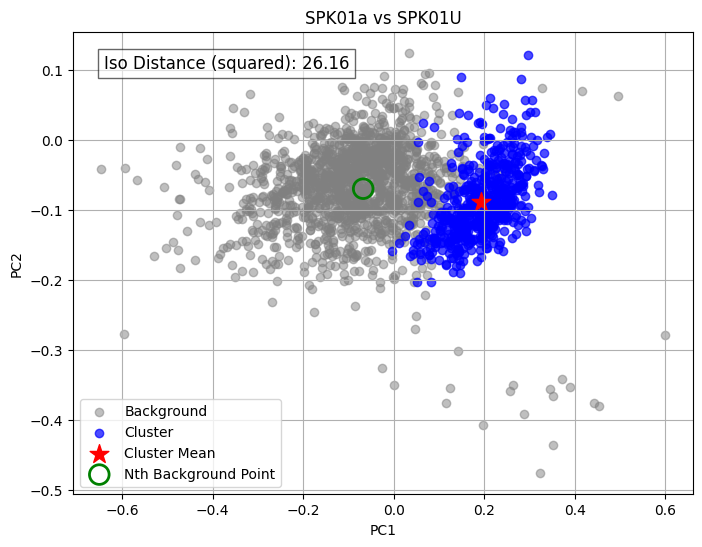

In [101]:
cluster_points = df[df["Name"]=="SPK01b_wf"][["PC1", "PC2", "PC3"]].values
background_points = df[df["Name"]=="SPK01U_wf"][["PC1", "PC2", "PC3"]].values

iso_val, nth_point = plot_iso_distance_scatter(cluster_points, background_points, title="SPK01a vs SPK01U")

In [103]:
import numpy as np
from scipy.stats import chi2

def compute_L_ratio(cluster, background, df=3):
    """
    Compute the L-ratio for a given spike cluster relative to a background set.
    
    Parameters:
      cluster: numpy array of shape (n_cluster, d), containing feature vectors (e.g. [PC1, PC2, PC3])
      background: numpy array of shape (n_background, d), containing feature vectors for background spikes
      df: degrees of freedom for the chi-square distribution (default is 3)
      
    Returns:
      L_ratio: the L-ratio value (lower values indicate better isolation)
    """
    n_cluster = cluster.shape[0]
    if n_cluster == 0:
        return np.nan

    # Calculate cluster mean and covariance
    mean_cluster = np.mean(cluster, axis=0)
    cov_cluster = np.cov(cluster, rowvar=False)
    
    try:
        inv_cov = np.linalg.inv(cov_cluster)
    except np.linalg.LinAlgError:
        print("Covariance matrix is singular. Returning NaN.")
        return np.nan

    # For each background spike, compute squared Mahalanobis distance and tail probability.
    L_sum = 0.0
    for x in background:
        d_sq = np.dot((x - mean_cluster).T, np.dot(inv_cov, (x - mean_cluster)))
        p_val = 1 - chi2.cdf(d_sq, df)  # tail probability for this distance
        L_sum += p_val

    L_ratio = L_sum / n_cluster
    return L_ratio



In [104]:
# Loop over channels and compute pairwise L-ratio comparisons ---
results = []
channels = df['Channel'].unique()

for ch in channels:
    # Select all spikes from this channel
    df_ch = df[df['Channel'] == ch]
    
    # Separate sorted units (UnitLetter != 'U') and unsorted spikes (UnitLetter == 'U')
    sorted_units = df_ch[df_ch['UnitLetter'] != 'U']
    unsorted_units = df_ch[df_ch['UnitLetter'] == 'U']
    
    # Get unique sorted unit letters (e.g., ['a', 'b', ...])
    sorted_unit_letters = sorted(sorted_units['UnitLetter'].unique())
    
    # Process channels that have at least one sorted unit.
    if len(sorted_unit_letters) == 0:
        continue

    # Comparison 1: For each sorted unit, compare to unsorted spikes (if available)
    if len(unsorted_units) > 0:
        for unit in sorted_unit_letters:
            cluster = sorted_units[sorted_units['UnitLetter'] == unit][['PC1', 'PC2', 'PC3']].values
            background = unsorted_units[['PC1', 'PC2', 'PC3']].values
            l_ratio = compute_L_ratio(cluster, background, df=3)
            results.append({'Channel': ch, 'Comparison': f"{unit} vs U", 'Lratio': l_ratio})
    
    # Comparison 2: For each pair of sorted units, compute L-ratio (one direction)
    if len(sorted_unit_letters) >= 2:
        for i in range(len(sorted_unit_letters)):
            for j in range(i + 1, len(sorted_unit_letters)):
                unit1 = sorted_unit_letters[i]
                unit2 = sorted_unit_letters[j]
                # Use unit2 as background for unit1
                cluster = sorted_units[sorted_units['UnitLetter'] == unit1][['PC1', 'PC2', 'PC3']].values
                background = sorted_units[sorted_units['UnitLetter'] == unit2][['PC1', 'PC2', 'PC3']].values
                l_ratio = compute_L_ratio(cluster, background, df=3)
                results.append({'Channel': ch, 'Comparison': f"{unit1} vs {unit2}", 'Lratio': l_ratio})

# Convert the results to a DataFrame and display it
results_df = pd.DataFrame(results)
print(results_df)

   Channel Comparison        Lratio
0    SPK01     a vs U  7.400266e-06
1    SPK01     b vs U  3.089767e-02
2    SPK01     a vs b  4.961996e-03
3    SPK04     a vs U  1.542471e-01
4    SPK05     a vs U  9.402331e-02
5    SPK06     a vs U  5.935347e+00
6    SPK29     a vs U  1.122745e-01
7    SPK30     a vs U  3.621257e-09
8    SPK30     b vs U  7.681653e-02
9    SPK30     a vs b  0.000000e+00
10   SPK31     a vs U  2.054477e-01
11   SPK32     a vs U  2.490221e-02
12   SPK35     a vs U  1.286740e-02
13   SPK36     a vs U  1.181744e-04
14   SPK36     b vs U  4.250244e-03
15   SPK36     a vs b  8.764729e-02
16   SPK37     a vs U  4.926450e-08
17   SPK37     b vs U  2.941083e-03
18   SPK37     c vs U  5.377949e-01
19   SPK37     a vs b  5.272604e-03
20   SPK37     a vs c  3.754098e-09
21   SPK37     b vs c  1.130405e-03
22   SPK42     a vs U  2.410055e-01
23   SPK43     a vs U  3.944400e+00
24   SPK49     a vs U  9.642588e-02
25   SPK49     b vs U  8.439034e-02
26   SPK49     a vs b  9.479

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from matplotlib.patches import Ellipse

def plot_iso_distance_scatter(cluster, background, confidence=0.99, title="Isolation Distance Plot"):
    """
    Plot a scatter of cluster and background points (using PC1 vs PC2), draw the confidence contour,
    and highlight the cluster mean and the n-th background point used to compute the isolation distance.
    
    Parameters:
      cluster: numpy array of shape (n_cluster, d) containing cluster spike features (e.g., PC1-3)
      background: numpy array of shape (n_background, d) containing background spike features
      confidence: Confidence level for the contour (default 0.99)
      title: Title of the plot
      
    Returns:
      iso_distance: The computed isolation distance (squared Mahalanobis distance)
      nth_point_2d: The background point (first two dimensions) corresponding to the isolation distance.
    """
    n_cluster = cluster.shape[0]
    
    # Compute cluster mean and covariance (using all dimensions for isolation distance calculation)
    mean_cluster = np.mean(cluster, axis=0)
    cov_cluster = np.cov(cluster, rowvar=False)
    
    try:
        inv_cov = np.linalg.inv(cov_cluster)
    except np.linalg.LinAlgError:
        print("Covariance matrix is singular. Cannot compute isolation distance.")
        return None
    
    # Compute squared Mahalanobis distances for each background point
    dists_sq = np.array([ (x - mean_cluster).T @ inv_cov @ (x - mean_cluster) for x in background ])
    
    # Sort the squared distances
    sorted_indices = np.argsort(dists_sq)
    
    # If there are not enough background points, use the farthest available point
    if len(sorted_indices) < n_cluster:
        nth_index = sorted_indices[-1]
        iso_distance = dists_sq[nth_index]
        reliability_flag = True  # flag as unreliable
    else:
        nth_index = sorted_indices[n_cluster - 1]
        iso_distance = dists_sq[nth_index]
        reliability_flag = False
    
    # For plotting, use only the first two principal components (PC1 and PC2)
    cluster_2d = cluster[:, :2]
    background_2d = background[:, :2]
    mean_cluster_2d = mean_cluster[:2]
    nth_point_2d = background[nth_index, :2]
    
    # Compute and plot the confidence contour for the cluster in 2D.
    # We'll compute the covariance of the 2D projection.
    cov_2d = np.cov(cluster_2d, rowvar=False)
    # For a 2D confidence ellipse, degrees of freedom = 2.
    threshold_val = chi2.ppf(confidence, df=2)
    eigvals, eigvecs = np.linalg.eigh(cov_2d)
    width = 2 * np.sqrt(eigvals[1] * threshold_val)
    height = 2 * np.sqrt(eigvals[0] * threshold_val)
    angle = np.degrees(np.arctan2(eigvecs[1, 1], eigvecs[0, 1]))
    ellipse = Ellipse(mean_cluster_2d, width, height, angle=angle, edgecolor='red', facecolor='none', lw=2, label=f'{int(confidence*100)}% Contour')
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(background_2d[:, 0], background_2d[:, 1], color="gray", alpha=0.5, label="Background")
    plt.scatter(cluster_2d[:, 0], cluster_2d[:, 1], color="blue", alpha=0.7, label="Cluster")
    plt.scatter(mean_cluster_2d[0], mean_cluster_2d[1], color="red", marker="*", s=200, label="Cluster Mean")
    plt.scatter(nth_point_2d[0], nth_point_2d[1], facecolors="none", edgecolors="green", s=200, linewidths=2, label="Nth Background Point")
    plt.gca().add_patch(ellipse)
    
    # Annotation: Show iso_distance and flag if unreliable.
    annotation = f"Iso Distance (squared): {iso_distance:.2f}"
    if reliability_flag:
        annotation += "\n(Unreliable: insufficient background spikes)"
    
    plt.text(0.05, 0.95, annotation, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment="top", bbox=dict(facecolor="white", alpha=0.6))
    
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    return iso_distance, nth_point_2d

# --- Example usage:
# Suppose you have your DataFrame 'df' with columns "PC1", "PC2", "PC3", and "Name".
# For instance, for channel 1:
#   - Sorted unit "SPK01a_wf": cluster points from df[df["Name"]=="SPK01a_wf"]
#   - Unsorted unit "SPK01U_wf": background points from df[df["Name"]=="SPK01U_wf"]
#
# Retrieve PC features as numpy arrays:
# cluster_points = df[df["Name"]=="SPK01a_wf"][["PC1", "PC2", "PC3"]].values
# background_points = df[df["Name"]=="SPK01U_wf"][["PC1", "PC2", "PC3"]].values
#
# iso_val, nth_pt = plot_iso_distance_scatter(cluster_points, background_points, confidence=0.99, title="SPK01a vs SPK01U")

SPK01: Unit a vs. Unsorted (U)


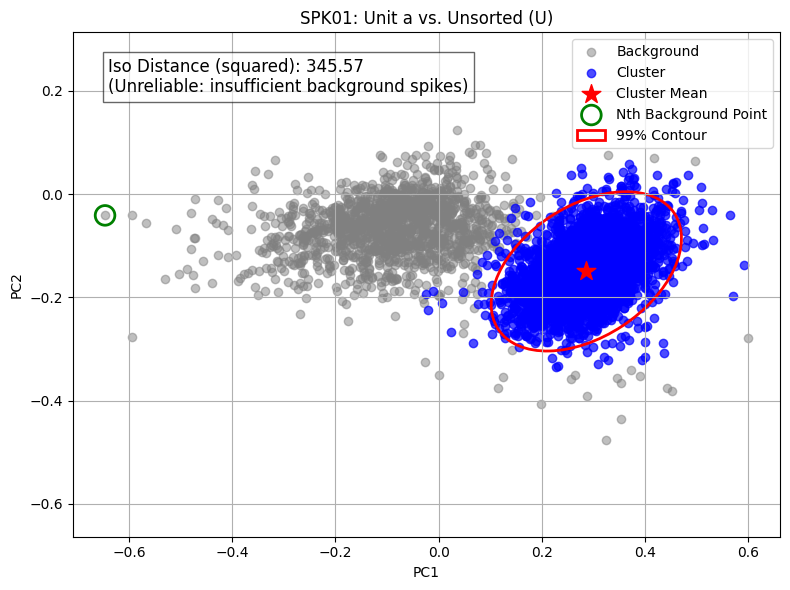

SPK01: Unit b vs. Unsorted (U)


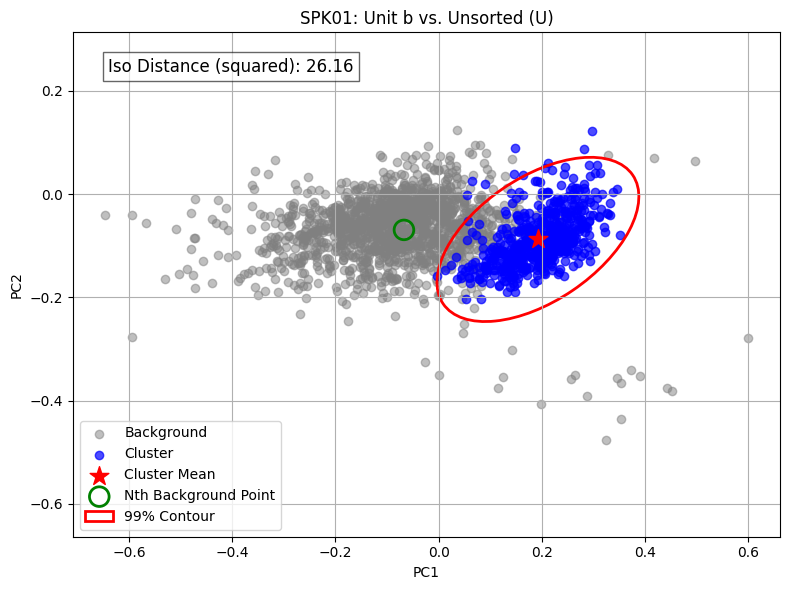

SPK01: Unit b (n=566) vs. Unit a (n=5485)


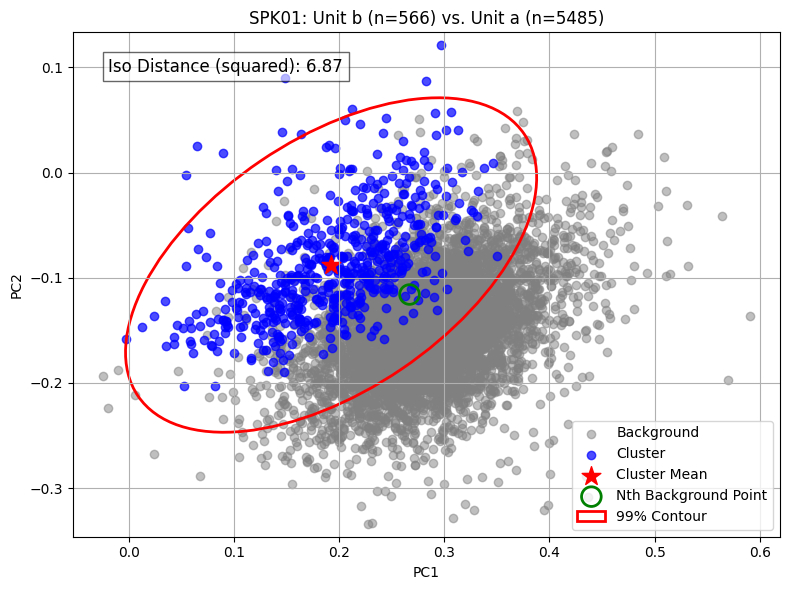

SPK04: Unit a vs. Unsorted (U)


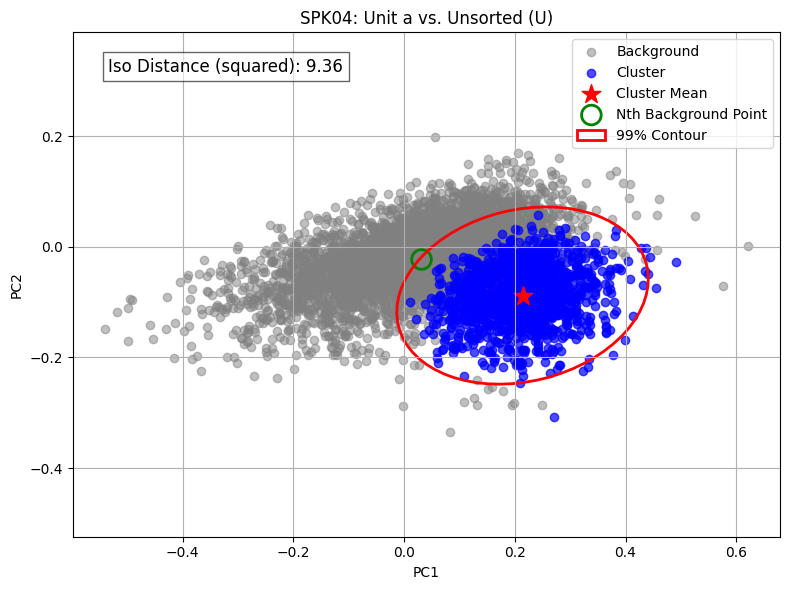

SPK05: Unit a vs. Unsorted (U)


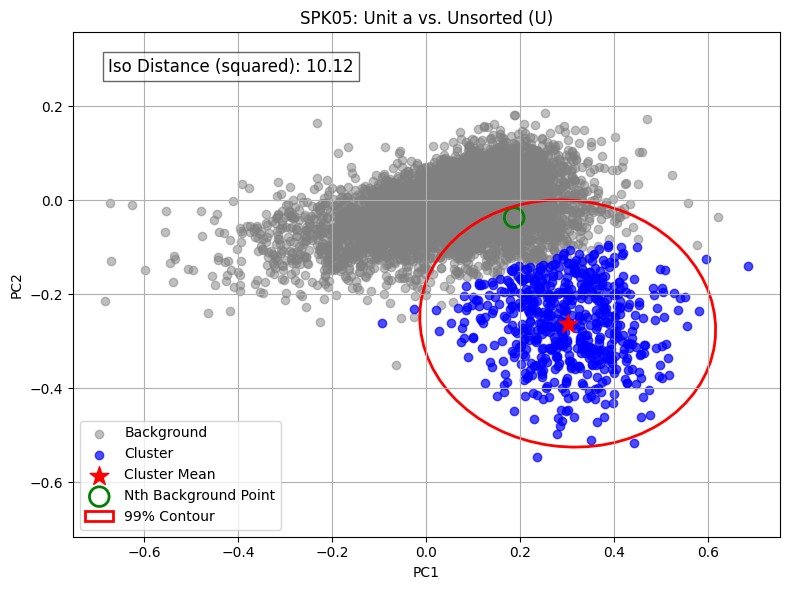

SPK06: Unit a vs. Unsorted (U)


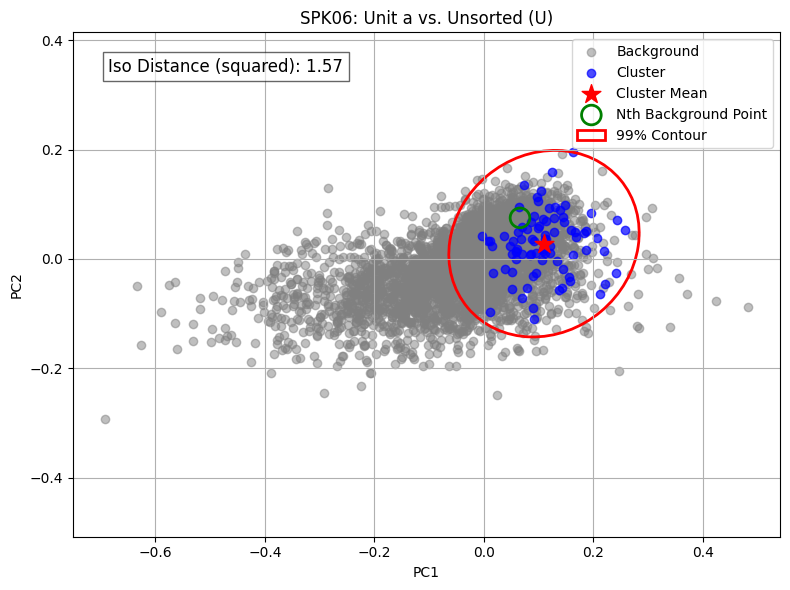

SPK29: Unit a vs. Unsorted (U)


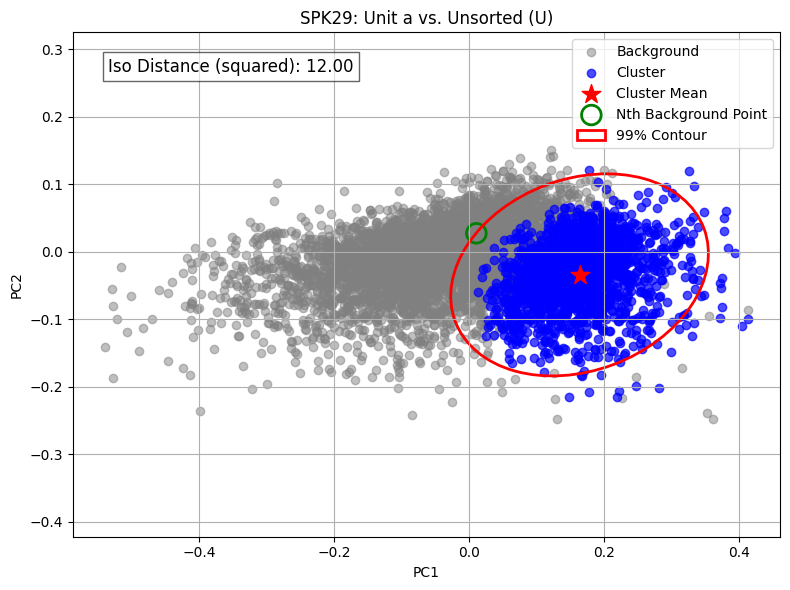

SPK30: Unit a vs. Unsorted (U)


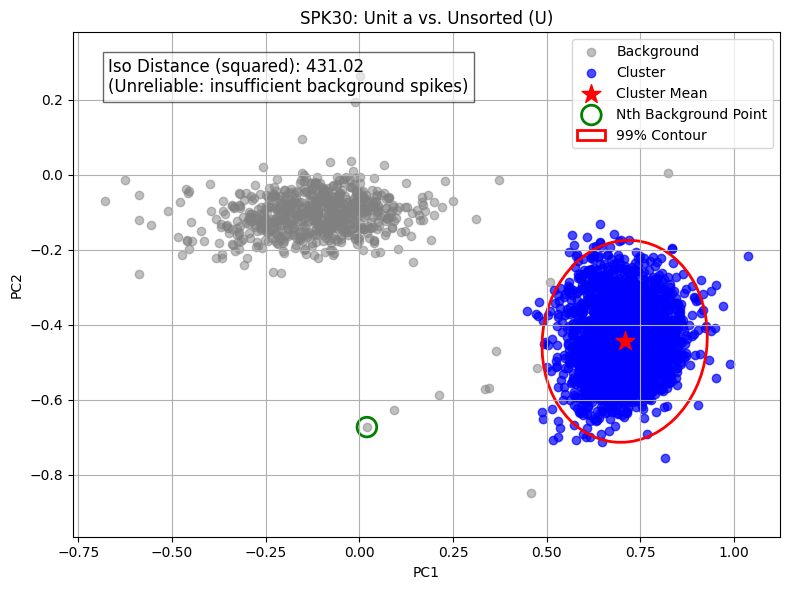

SPK30: Unit b vs. Unsorted (U)


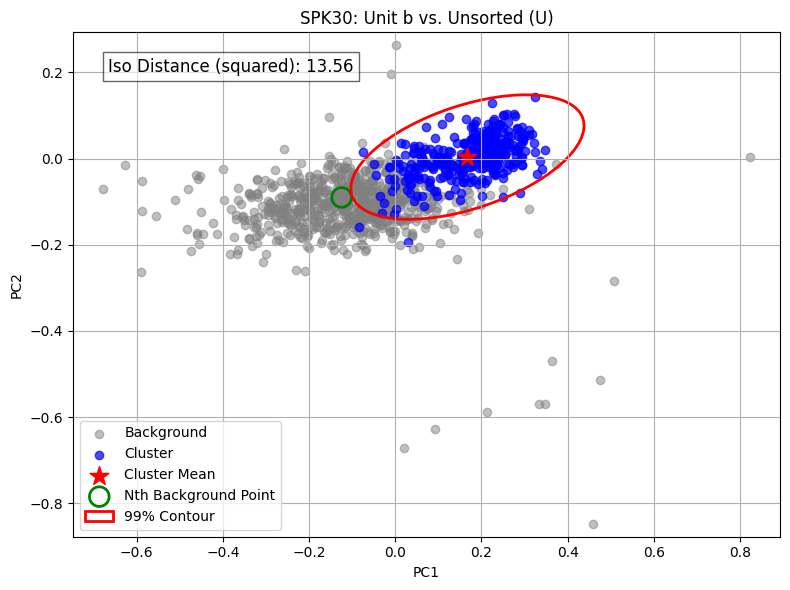

SPK30: Unit b (n=340) vs. Unit a (n=3016)


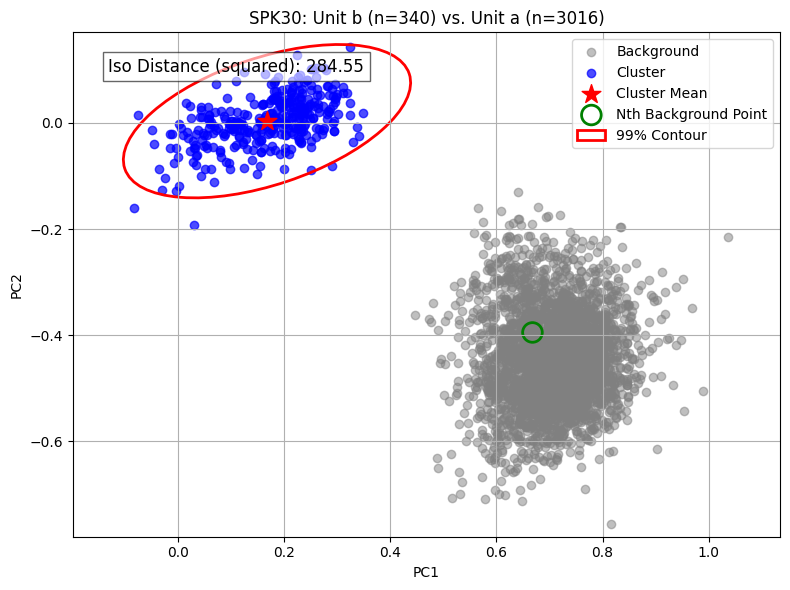

SPK31: Unit a vs. Unsorted (U)


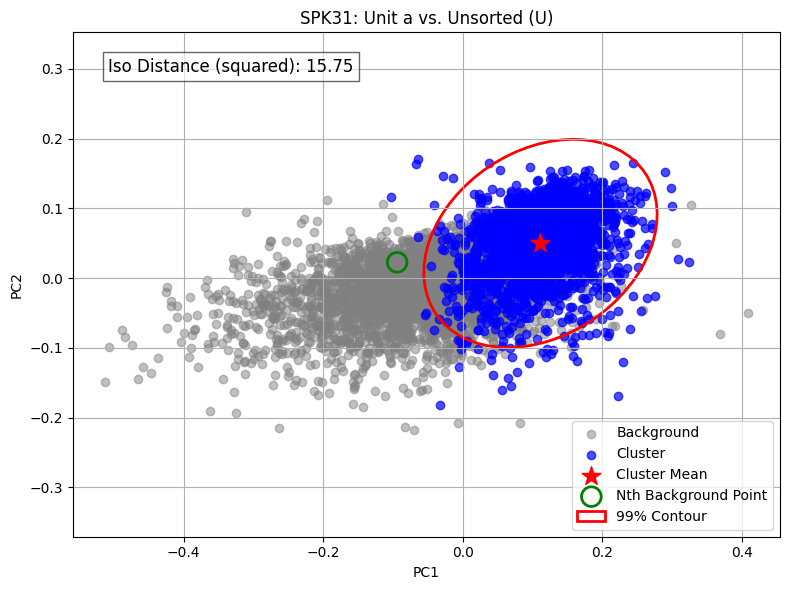

SPK32: Unit a vs. Unsorted (U)


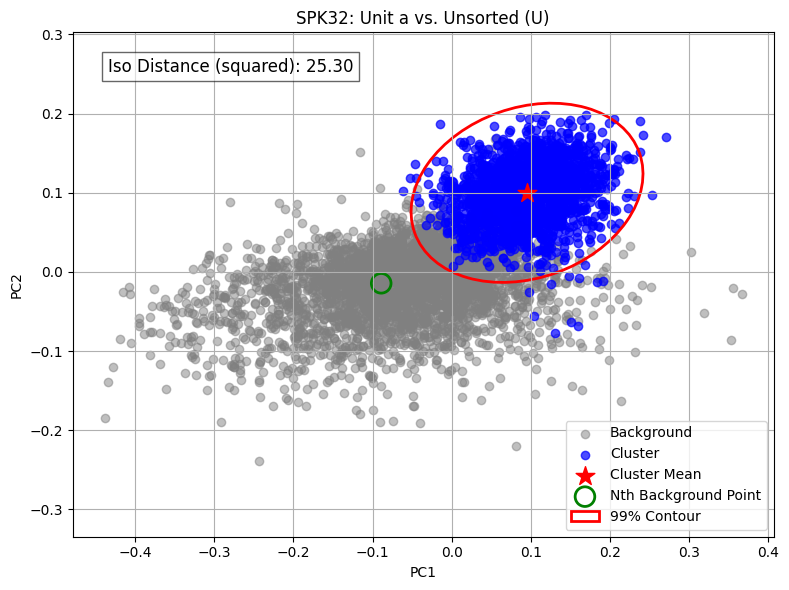

SPK35: Unit a vs. Unsorted (U)


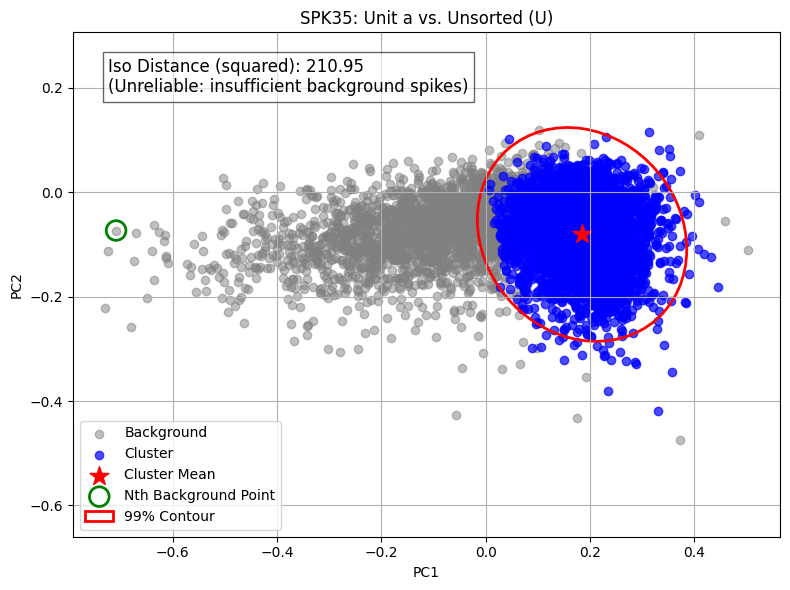

SPK36: Unit a vs. Unsorted (U)


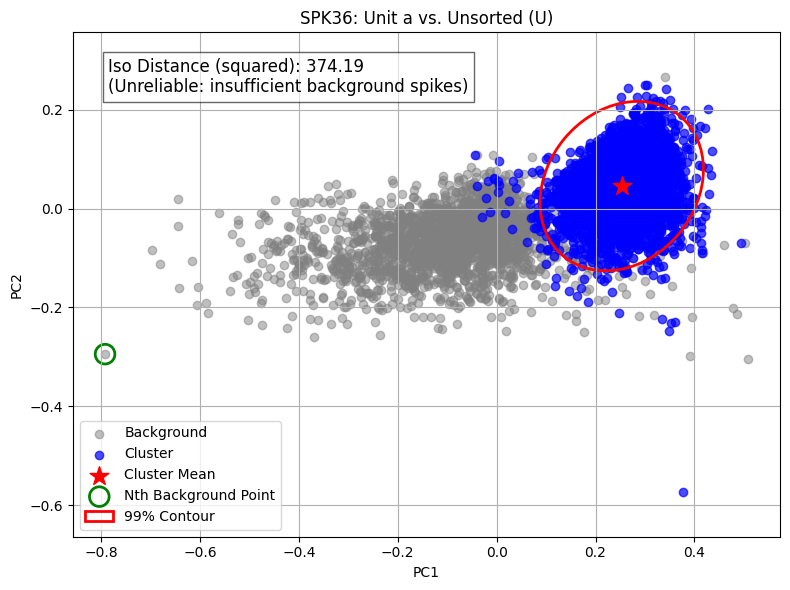

SPK36: Unit b vs. Unsorted (U)


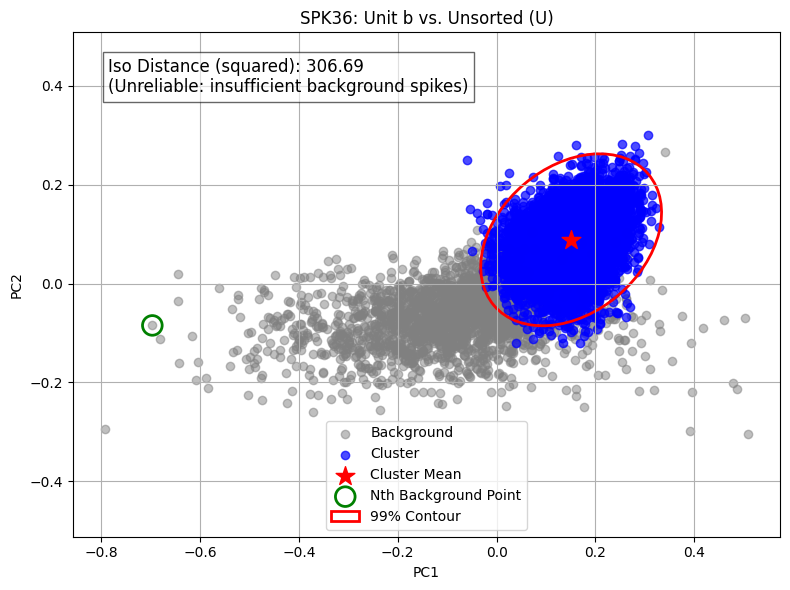

SPK36: Unit a (n=5320) vs. Unit b (n=6467)


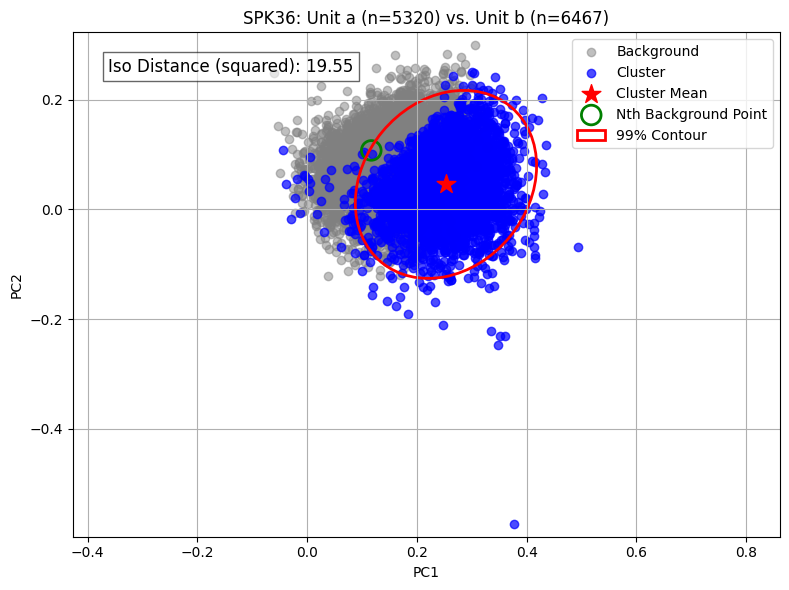

SPK37: Unit a vs. Unsorted (U)


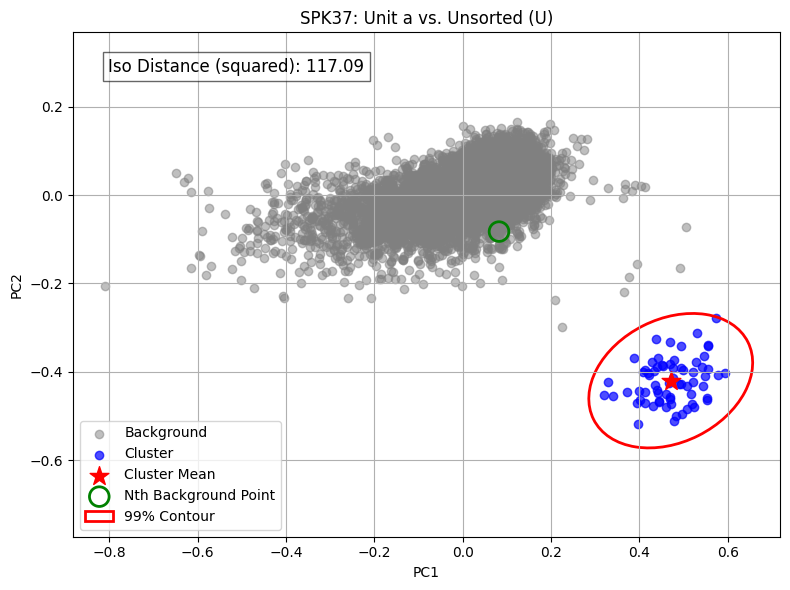

SPK37: Unit b vs. Unsorted (U)


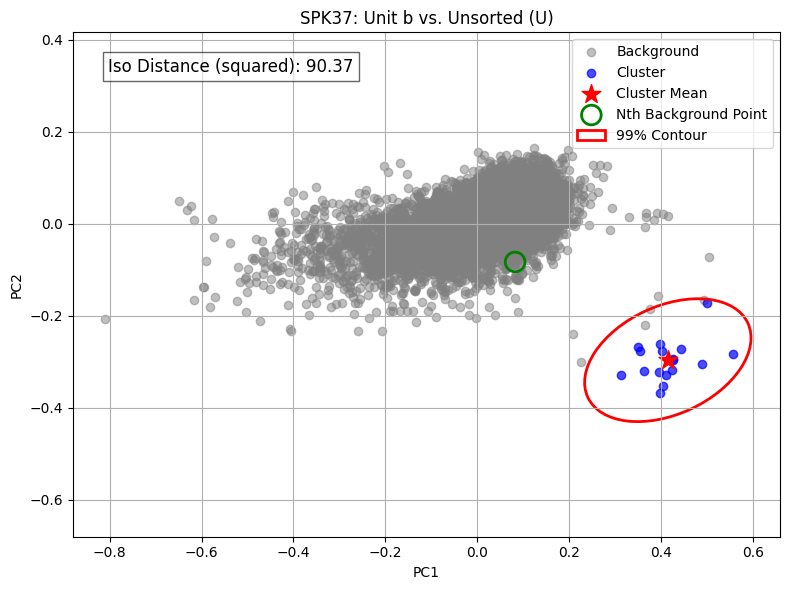

SPK37: Unit c vs. Unsorted (U)


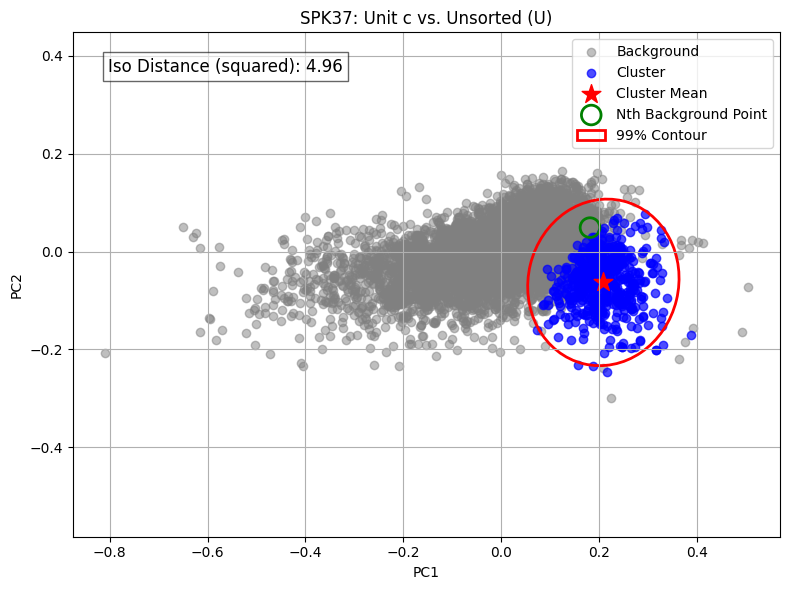

SPK37: Unit b (n=17) vs. Unit a (n=68)


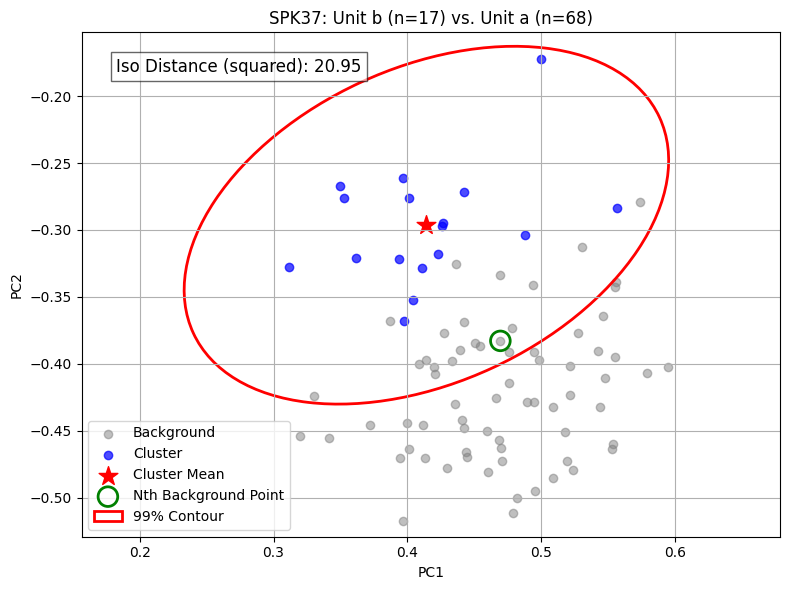

SPK37: Unit a (n=68) vs. Unit c (n=501)


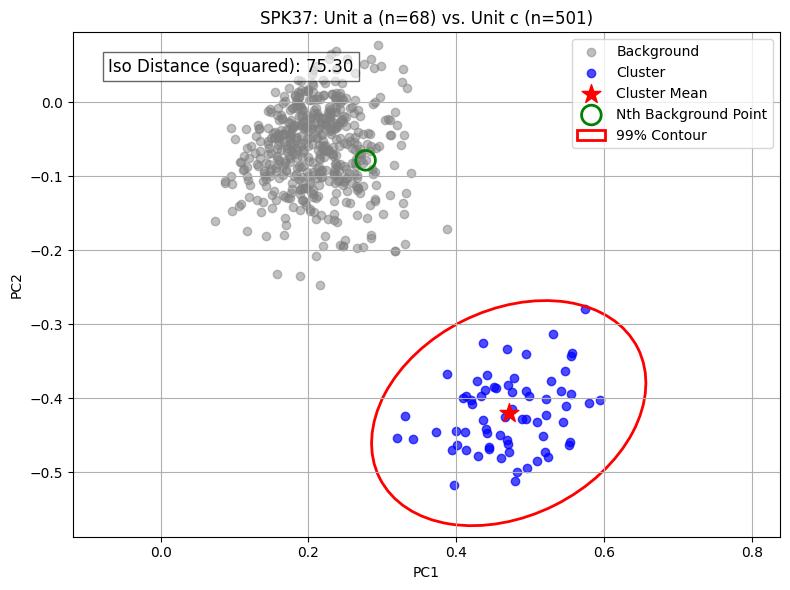

SPK37: Unit b (n=17) vs. Unit c (n=501)


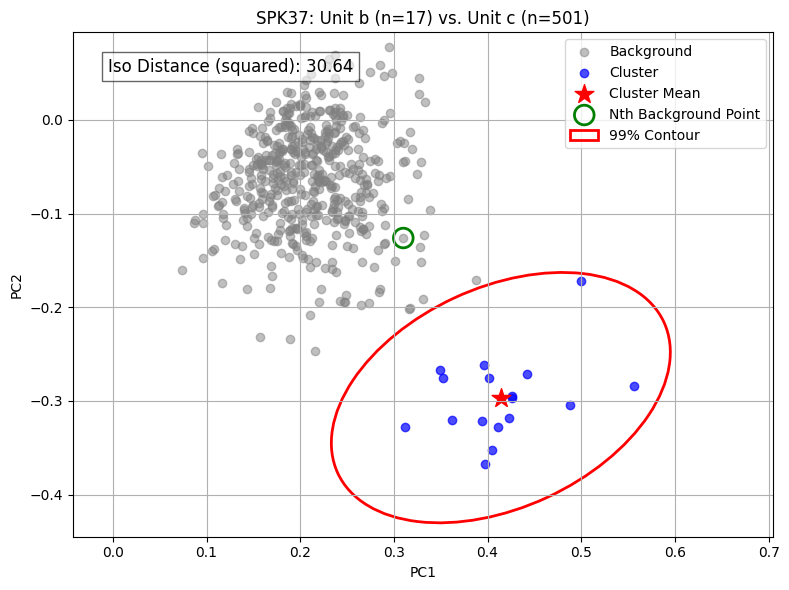

SPK42: Unit a vs. Unsorted (U)


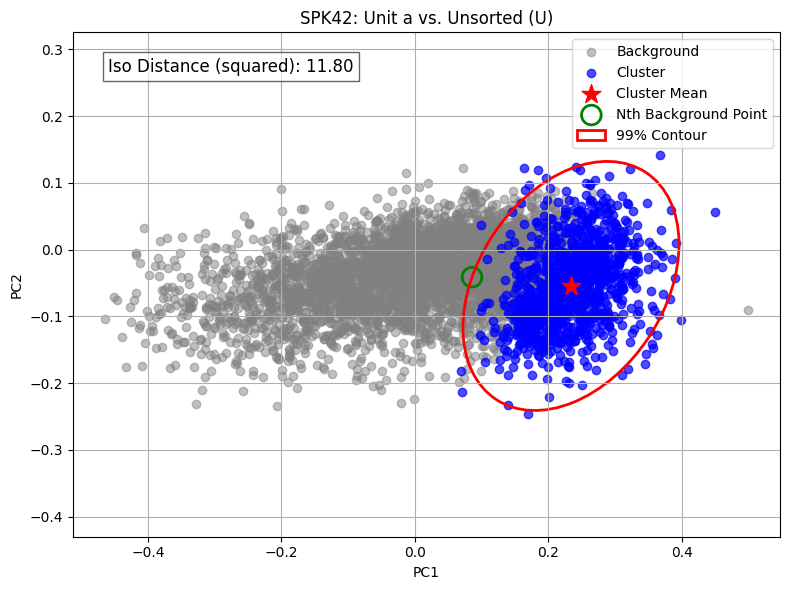

SPK43: Unit a vs. Unsorted (U)


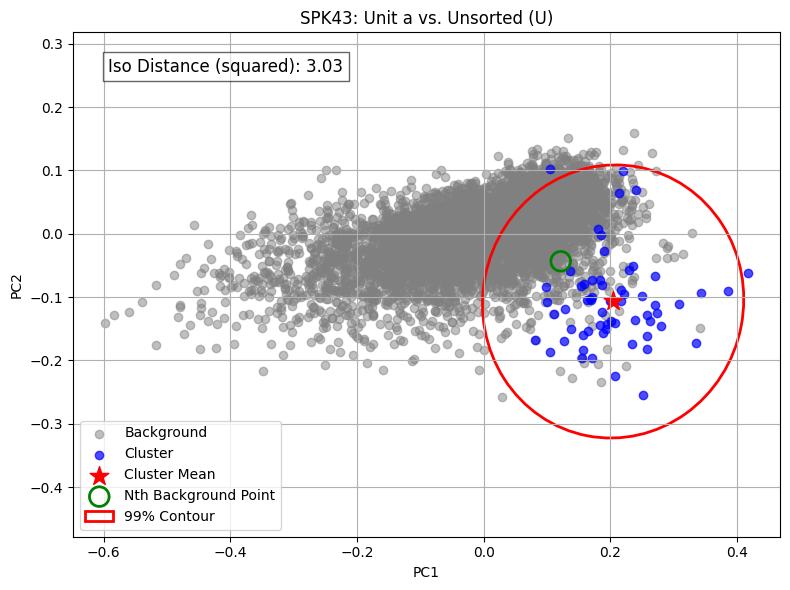

SPK49: Unit a vs. Unsorted (U)


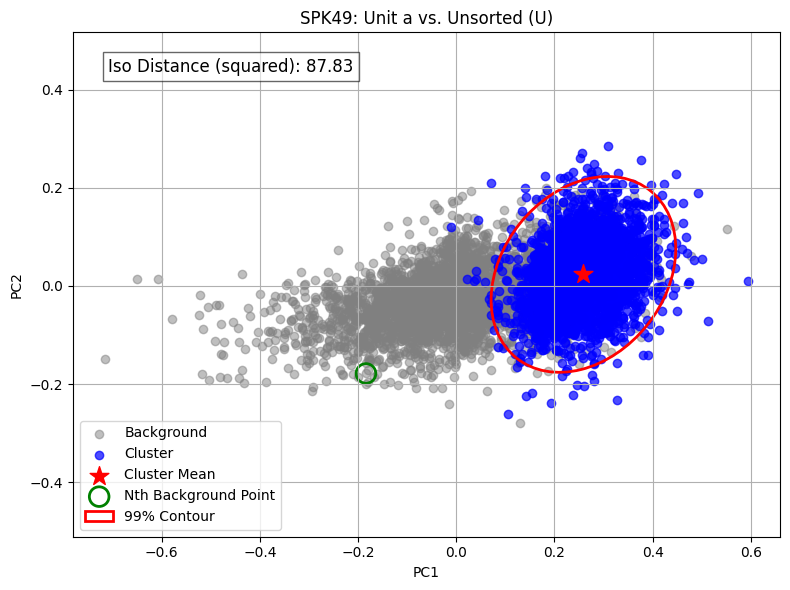

SPK49: Unit b vs. Unsorted (U)


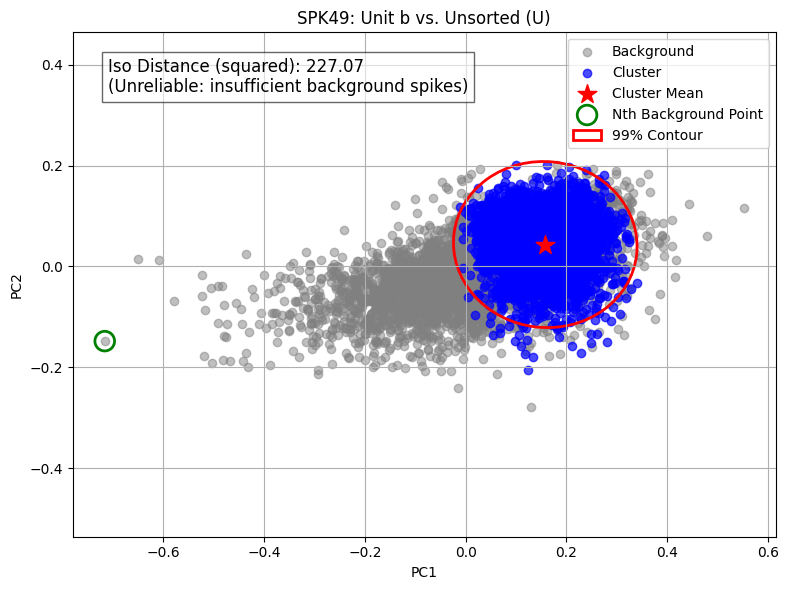

SPK49: Unit a (n=3587) vs. Unit b (n=4118)


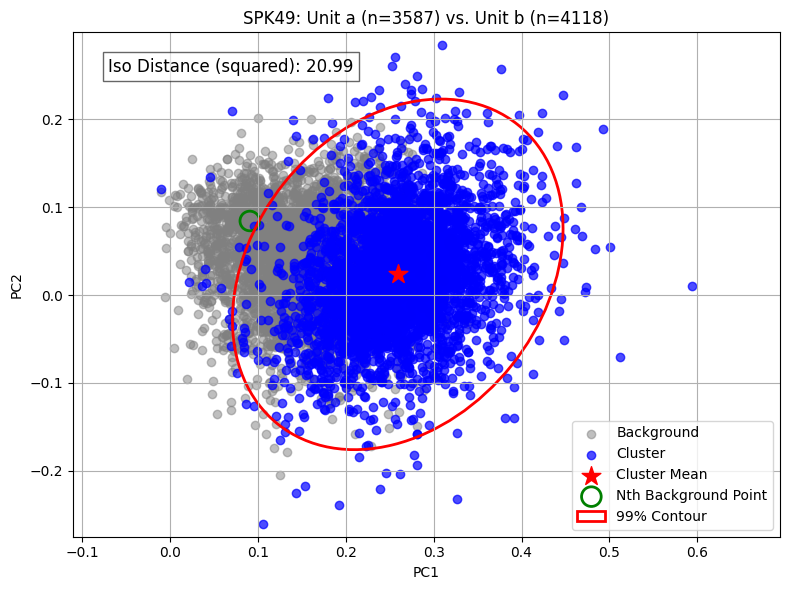

SPK50: Unit a vs. Unsorted (U)


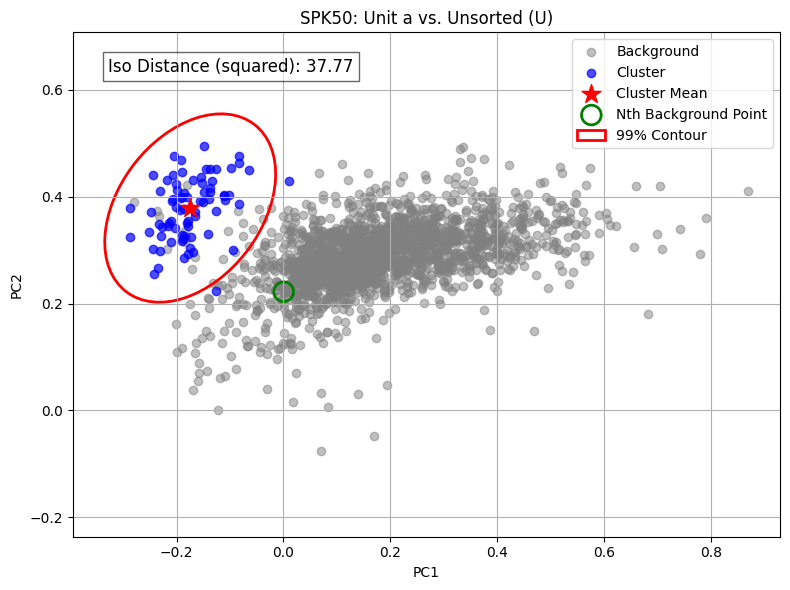

SPK50: Unit b vs. Unsorted (U)


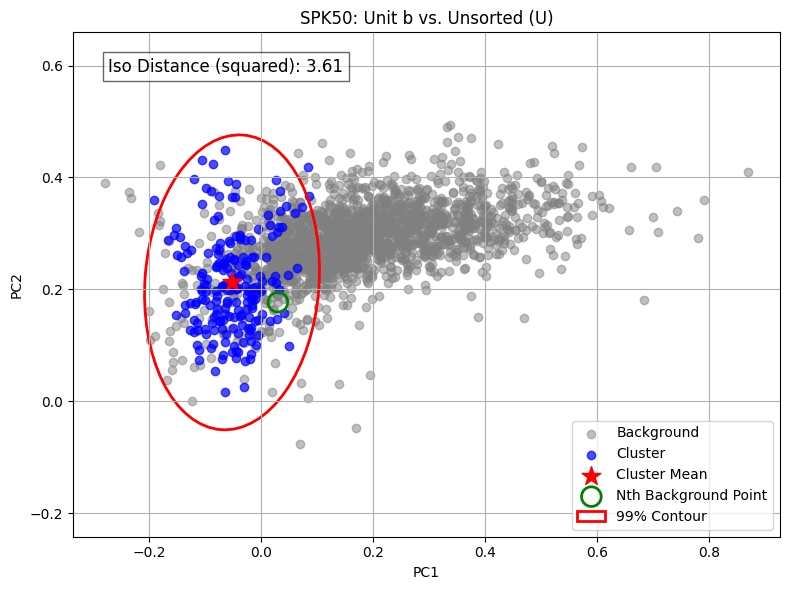

SPK50: Unit a (n=76) vs. Unit b (n=198)


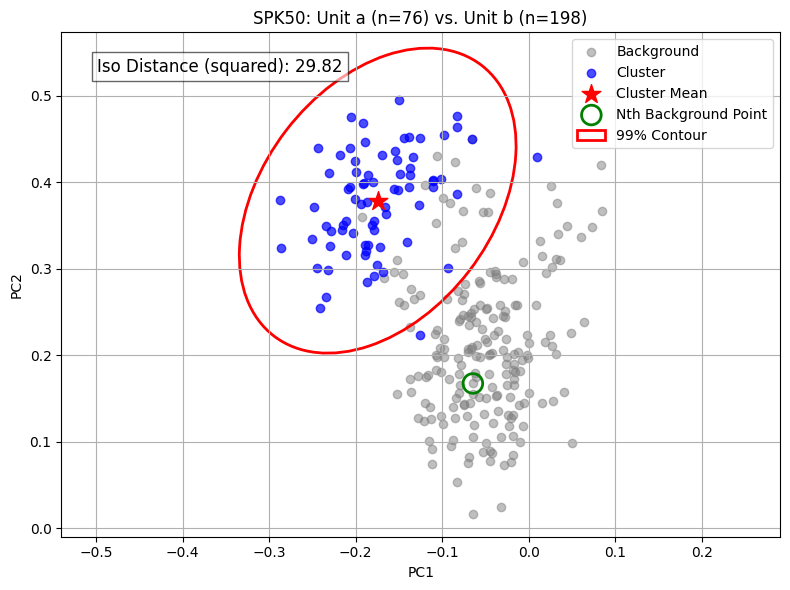

SPK53: Unit a vs. Unsorted (U)


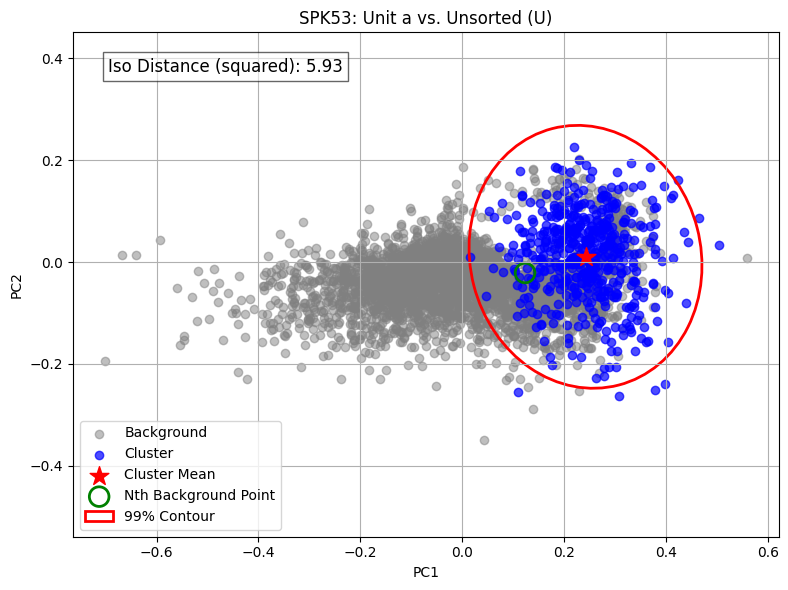

SPK53: Unit b vs. Unsorted (U)


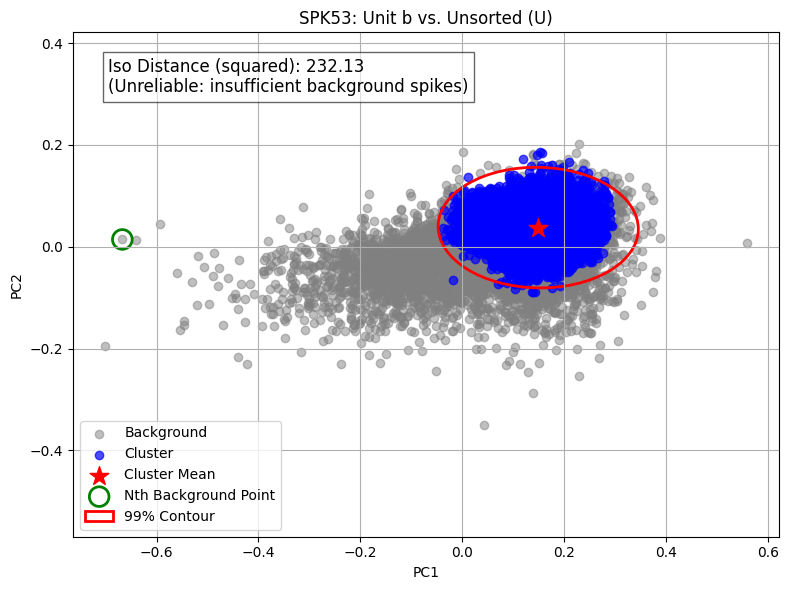

SPK53: Unit a (n=509) vs. Unit b (n=5821)


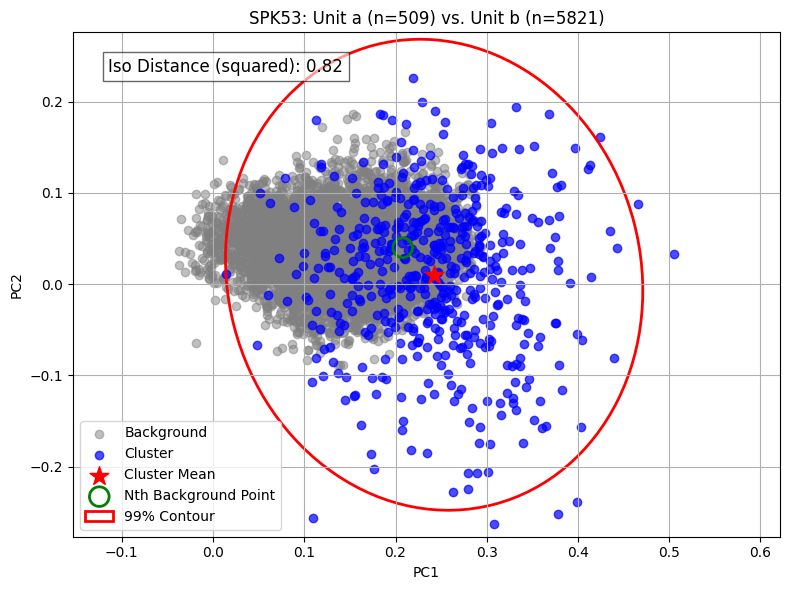

SPK61: Unit a vs. Unsorted (U)


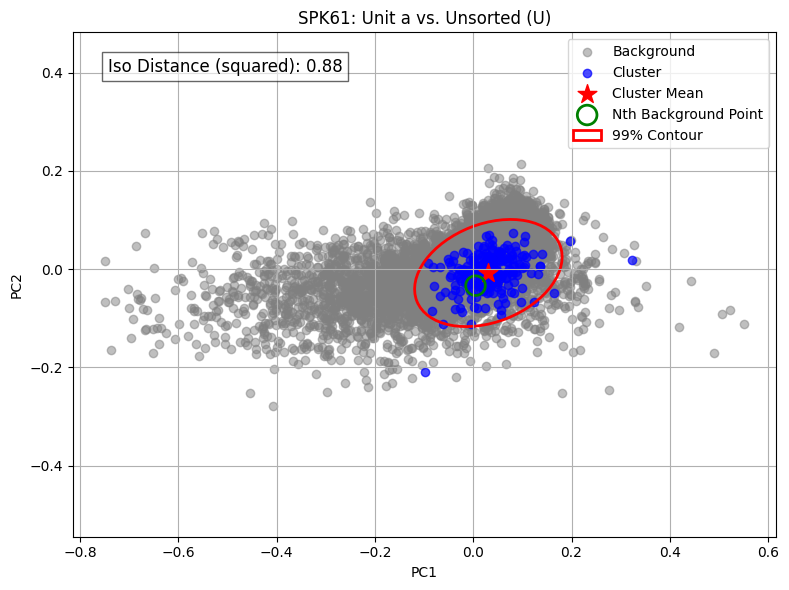

In [109]:
# Loop over each channel in the DataFrame
channels = df['Channel'].unique()

for ch in channels:
    # Select all spikes for this channel
    df_ch = df[df['Channel'] == ch]
    
    # Separate sorted units (UnitLetter != 'U') and unsorted spikes (UnitLetter == 'U')
    sorted_units = df_ch[df_ch['UnitLetter'] != 'U']
    unsorted_units = df_ch[df_ch['UnitLetter'] == 'U']
    
    # Get unique sorted unit letters (e.g., ['a', 'b', ...])
    sorted_unit_letters = sorted(sorted_units['UnitLetter'].unique())
    
    # Process only if there is at least one sorted unit
    if len(sorted_unit_letters) == 0:
        continue

    # --- Comparison 1: Sorted unit vs. Unsorted spikes ---
    if len(unsorted_units) > 0:
        for unit in sorted_unit_letters:
            # Get PC features for the sorted unit (cluster)
            cluster = sorted_units[sorted_units['UnitLetter'] == unit][["PC1", "PC2", "PC3"]].values
            # Get PC features for the unsorted spikes (background)
            background = unsorted_units[["PC1", "PC2", "PC3"]].values
            # Create a title for the plot
            title = f"{ch}: Unit {unit} vs. Unsorted (U)"
            print(title)
            # Call the function to plot isolation distance scatter plot
            iso_distance, nth_point = plot_iso_distance_scatter(cluster, background, confidence=0.99, title=title)
    
    # --- Comparison 2: Sorted unit vs. Sorted unit (using the smaller cluster as "cluster") ---
    if len(sorted_unit_letters) >= 2:
        for i in range(len(sorted_unit_letters)):
            for j in range(i + 1, len(sorted_unit_letters)):
                unit1 = sorted_unit_letters[i]
                unit2 = sorted_unit_letters[j]
                # Get PC features for both units and count them
                data_unit1 = sorted_units[sorted_units['UnitLetter'] == unit1][["PC1", "PC2", "PC3"]].values
                data_unit2 = sorted_units[sorted_units['UnitLetter'] == unit2][["PC1", "PC2", "PC3"]].values
                count1 = data_unit1.shape[0]
                count2 = data_unit2.shape[0]
                
                # Use the unit with fewer spikes as the cluster and the one with more spikes as the background
                if count1 <= count2:
                    cluster = data_unit1
                    background = data_unit2
                    title = f"{ch}: Unit {unit1} (n={count1}) vs. Unit {unit2} (n={count2})"
                else:
                    cluster = data_unit2
                    background = data_unit1
                    title = f"{ch}: Unit {unit2} (n={count2}) vs. Unit {unit1} (n={count1})"
                
                print(title)
                iso_distance, nth_point = plot_iso_distance_scatter(cluster, background, confidence=0.99, title=title)